## **Advanced RAG Exploration**

Here, we will explore how to improve upon naive RAG in various parts of the RAG pipeline.

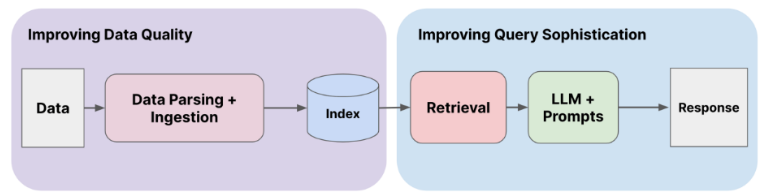

In [52]:
import glob
import pickle
import itertools
import nest_asyncio
from dotenv import load_dotenv
import os

from llama_parse import LlamaParse
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core.extractors import (SummaryExtractor,TitleExtractor)
from llama_index.core.node_parser import (SentenceSplitter,SemanticSplitterNodeParser,MarkdownElementNodeParser)
from llama_index.core import VectorStoreIndex
from llama_index.core.query_engine import RetryQueryEngine

from llama_index.core.evaluation import RelevancyEvaluator,FaithfulnessEvaluator
from llama_index.core.llama_dataset.generator import RagDatasetGenerator
from llama_index.core.llama_pack import download_llama_pack


In [2]:
# Load environment variables from .env file
load_dotenv()

nest_asyncio.apply()

openai_api_key = os.getenv("OPENAI_API_KEY")
llama_cloud_api_key = os.getenv("LLAMA_CLOUD_API_KEY")

### 1) Loading Documents

First, we improve the data quality which consists of loading, chunking, and embedding our data. 

The data that we wish store as our LLM's domain knowledge includes PDF files, but PDF files are not a LLM-friendly file format. To provide our LLM with data that is more understandable, we first represent our PDF files as markdown files. We do this by using a multi-modal LLM (GPT-4o in our case) with predefined instructions to read our PDF files and convert them into a markdown file. Using a multi-modal model allows us to extract summaries, text, and/or structure from embedded figures and tables in our PDF files. 

We use LlamaParse which provides us with a convenient framework to use GPT-4o with instructions to load our PDF files. 

#### 1.1 Quzizes and Exams

In [4]:
# Instructions for Quizzes and Exams
parsingInstruction_QE = """The provided document is an exam or quiz for a course on introductory computer science and programming. 
There are different types of questions, including multiple choice, fill in the blank, and short answer questions. 
Answers to the questions may or may not be provided. 
The goal for you is to extract the concepts tested on the exam/quiz and what is being asked by each question. 
The goal is to help the students solve the questions by teaching the concept instead of giving them the answers.
"""

In [5]:
withInstructionParsing = LlamaParse(
                                result_type="markdown", 
                                parsing_instruction=parsingInstruction_QE,
                                gpt4o_mode=True
                            )

In [10]:
# List all pdf files in a directory
QE = glob.glob("GSU - CIS 3260 - Fall 2023/Quizzes and Exams/*.pdf")  # Adjust the path to your directory containing CSV files

In [138]:
QE[3:]

['GSU - CIS 3260 - Fall 2023/Quizzes and Exams/Quiz 3 with KEY.pdf',
 'GSU - CIS 3260 - Fall 2023/Quizzes and Exams/Quiz 1 with KEY.pdf',
 'GSU - CIS 3260 - Fall 2023/Quizzes and Exams/Quiz 2 with KEY.pdf',
 'GSU - CIS 3260 - Fall 2023/Quizzes and Exams/Quiz 4 with KEY.pdf']

In [139]:
for pdf_file in QE[3:]:
    # Generate a unique name for each .pkl file based on the PDF file name
    pkl_filename = os.path.basename(pdf_file).replace('.pdf', '.pkl')
    pkl_filepath = os.path.join("GSU - CIS 3260 - Fall 2023/Quizzes and Exams", pkl_filename)

    # Load and parse the data
    document = withInstructionParsing.load_data(pdf_file) 
    # Save the parsed document to a .pkl file
    with open(pkl_filepath, 'wb') as f:
        pickle.dump(document, f)
    print(f"Saved parsed document to {pkl_filepath}")

Started parsing the file under job_id db4819ef-fc07-4d27-a67c-ddae17a551e3
Saved parsed document to GSU - CIS 3260 - Fall 2023/Quizzes and Exams/Quiz 3 with KEY.pkl
Started parsing the file under job_id bc444d59-bf49-4c47-96ff-a637354f5a0c
Saved parsed document to GSU - CIS 3260 - Fall 2023/Quizzes and Exams/Quiz 1 with KEY.pkl
Started parsing the file under job_id d6b4f634-2595-46f6-b0cf-e5dcd2026455
Saved parsed document to GSU - CIS 3260 - Fall 2023/Quizzes and Exams/Quiz 2 with KEY.pkl
Started parsing the file under job_id 65c6867d-4081-4cc7-ad33-130221358fa6
Saved parsed document to GSU - CIS 3260 - Fall 2023/Quizzes and Exams/Quiz 4 with KEY.pkl


#### 1.2 Syllabus and Lecture Slides

In [154]:
# Instructions to Parser
parsingInstruction1 = """The provided document is a lecture slide for a course on introductory programming and computer science. 
Convert the provided document content into markdown file format. 

Note that there are embedded figures, bullet points, code snippets, flowcharts, etc. 

Infer what each page is trying convey and summarize the contents.

If you encounter a flowchart or an image, give a summary or explanation of it while also extracting text and structure of it. If possible, also related to the concept being conveyed or discussed.  

Also, try to extract the structure, hierarchy, and formatting of the contents where texts exist.
"""

In [155]:
withInstructionParsing1 = LlamaParse(
                                result_type="markdown", 
                                parsing_instruction=parsingInstruction1,
                                gpt4o_mode=True
                            )

In [141]:
# List all pdf files in a directory
import glob
lec_slides = glob.glob("GSU - CIS 3260 - Fall 2023/Lecture Slides Parsed/*.pdf")  # Adjust the path to your directory containing CSV files
import re
def extract_week_number(file_path):
    match = re.search(r"Week (\d+)", file_path)
    return int(match.group(1)) if match else None

# Sort files based on the week number
sorted_files = sorted(lec_slides, key=extract_week_number)


In [143]:
sorted_files[5:7]

['GSU - CIS 3260 - Fall 2023/Lecture Slides Parsed/Week 7.pdf',
 'GSU - CIS 3260 - Fall 2023/Lecture Slides Parsed/Week 8.pdf']

In [160]:
document = withInstructionParsing1.load_data('GSU - CIS 3260 - Fall 2023/Lecture Slides Parsed/Week 8.pdf')

Started parsing the file under job_id c1d36ada-053f-41d2-80d6-79d0cf0203e9
.

In [161]:
pkl_filename = os.path.basename(sorted_files[6]).replace('.pdf', '.pkl')
pkl_filepath = os.path.join("GSU - CIS 3260 - Fall 2023/Lecture Slides Parsed", pkl_filename)


In [162]:
    # Save the parsed document to a .pkl file
    with open(pkl_filepath, 'wb') as f:
        pickle.dump(document, f)
    print(f"Saved parsed document to {pkl_filepath}")

Saved parsed document to GSU - CIS 3260 - Fall 2023/Lecture Slides Parsed/Week 8.pkl


#### 1.3) Load our Markdown files 

In [6]:
md_lec_slides = glob.glob("GSU - CIS 3260 - Fall 2023/Lecture Slides Parsed/*.pkl") 
md_lec_slides
# List to store loaded documents
documents = []

# Loop through file numbers 1 through 8
for i in md_lec_slides:  # 9 is exclusive, so it goes from 1 to 8
    doc = pickle.load(open(i, "rb"))
    documents.append(doc)

md_qe = glob.glob("GSU - CIS 3260 - Fall 2023/Quizzes and Exams/*.pkl") 
# Loop through file numbers 1 through 8
for i in md_qe:  # 9 is exclusive, so it goes from 1 to 8
    doc = pickle.load(open(i, "rb"))
    documents.append(doc)
    
# Load Syllabus 
doc1 = pickle.load(open("GSU - CIS 3260 - Fall 2023/Syllabus Parsed/demo.pkl", "rb"))
documents.append(doc1)

In [7]:
documents

[[Document(id_='720eb6d8-4f68-4a81-a717-8c42d2eb139c', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='# Objectives for class 14\n\n- Review IA4-IA7\n- Review Quiz 3 – Quiz 5\n- Final Exam Schedule\n- Group Project Schedule\n---\n# Individual Assignment 4 - 2\n\n- Enter a letter grade A/a, B/b, C/c, D/d, and then displays its corresponding numeric value 90, 80, 70, 60.\n\n## Sample Run\n```\nEnter a letter grade: B\nThe numeric value for grade B is 80\n```\n\n```python\nletter = input("Enter a letter grade: ")\n\nif letter in \'Aa\':\n    print("The numeric value for grade A is 90")\nelif letter in \'Bb\':\n    print("The numeric value for grade B is 80")\nelif letter in \'Cc\':\n    print("The numeric value for grade C is 70")\nelif letter in \'Dd\':\n    print("The numeric value for grade D is 60")\nelse:\n    print(letter, "is an invalid grade")\n```\n\n- Letter in “Aa”\n- Multiple way if statements\n---\n# Individ

In [8]:
len(documents)

21

### 2) Chunk 

The second part to improving our data quality is to meaningfully chunk our documents. To do this, we divert from the usual fixed chunking methods and test various advanced chunking strategies.

#### 2.1 Semantic Chunker

The first method we test is the semantic chunking strategy. This method is as follows:
1. Chunk our documents into fixed chunks 
2. Embed the chunks 
3. Obtain the indices where there is the largest distance of semantic similarity between embeddings (i.e. whether the embeddings are most different)
4. Chunk the original documents at these indices

https://docs.llamaindex.ai/en/stable/examples/node_parsers/semantic_chunking/

In [53]:
# Semantic splitter
splitter = SemanticSplitterNodeParser(
    buffer_size=1, breakpoint_percentile_threshold=95, embed_model=OpenAIEmbedding(model = "text-embedding-3-large")
)

In [54]:
nodes_semantic = []

for doc in documents:
    pdoc = splitter.get_nodes_from_documents(doc)
    nodes_semantic.append(pdoc)

In [14]:
print(nodes_semantic[1][2])

Node ID: 9e3792d1-9a08-454b-8c26-98416a764218
Text: - **String** literals enclosed in matching *single quotes* (`'`)
or *double quotes* (`"`).  ```python letter = 'A'  # Same as letter =
"A" numChar = '4'  # Same as numChar = "4" message = "Good morning" #
Same as message = 'Good morning' ``` --- # Unicode/ASCII Assigns a
Code to a Character  - A specification - List every character and
assign ea...


In [181]:
print(nodes_semantic[1][2].get_content())

- **String** literals enclosed in matching *single quotes* (`'`) or *double quotes* (`"`).

```python
letter = 'A'  # Same as letter = "A"
numChar = '4'  # Same as numChar = "4"
message = "Good morning"
# Same as message = 'Good morning'
```
---
# Unicode/ASCII Assigns a Code to a Character

- A specification
- List every character and assign each character a unique code.
- Rules translating characters into bytes are called **encoding**.

## Python

```
'4'
```

## Encoded as

```
00000000 00110100
00000000 00000100
```
---
# ASCII Table and Description

| Dec | Hx | Oct | Char | Description                  | Dec | Hx | Oct | Html  | Chr | Dec | Hx | Oct | Html  | Chr |
|-----|----|-----|------|------------------------------|-----|----|-----|-------|-----|-----|----|-----|-------|-----|
| 0   | 0  | 000 | NUL  | (null)                       | 32  | 20 | 040 | &#32; | Space | 64  | 40 | 100 | &#64;  | @   |
| 1   | 1  | 001 | SOH  | (start of heading)           | 33  | 21 | 041 | &#33;

#### 2.2 Markdown Parser
We test the MarkdownElementNodeParser which splits a markdown document into text nodes and index nodes, which consists of embedded objecs, such as tables. This methods provides a chunk for the embedded objects themselves and summaries of them. 

In [16]:
from llama_index.core.node_parser import MarkdownElementNodeParser
from llama_index.llms.openai import OpenAI

node_parser = MarkdownElementNodeParser(
    llm=OpenAI(model="gpt-4"), num_workers=8
)

In [17]:
nodes = []
base_nodes = []
objects = []

for doc in documents:
    pdoc = node_parser.get_nodes_from_documents(doc)
    nodes.append(pdoc)
    base, obj = node_parser.get_nodes_and_objects(pdoc)
    base_nodes.append(base)
    objects.append(obj)

2it [00:00, 7724.32it/s]
  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:10<00:00,  5.08s/it]
4it [00:00, 29382.16it/s]
100%|██████████| 4/4 [00:10<00:00,  2.57s/it]
1it [00:00, 6105.25it/s]
100%|██████████| 1/1 [00:07<00:00,  7.95s/it]
4it [00:00, 31835.32it/s]
100%|██████████| 4/4 [00:11<00:00,  2.78s/it]
2it [00:00, 13706.88it/s]
100%|██████████| 2/2 [00:07<00:00,  3.58s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
5it [00:00, 35484.81it/s]
100%|██████████| 5/5 [00:04<00:00,  1.02it/s]
2it [00:00, 22075.28it/s]
100%|██████████| 2/2 [00:06<00:00,  3.11s/it]
5it [00:00, 26479.19it/s]
100%|██████████| 5/5 [00:07<00:00,  1.49s/it]
4it [00:00, 8015.87it/s]
100%|██████████| 4/4 [00:03<00:00,  1.04it/s]
6it [00:00, 31536.12it/s]
100%|██████████| 6/6 [00:20<00:00,  3.37s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
4it [00:00, 19440.57it/s]
100%|██████████| 4/4 [00:04<00:00,  1.13s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:00, 3024.01it/s]
100%|██████████| 1/1 [00:07<00:00,  7.42s/it]
0it [00:00, ?

In [400]:
base_nodes[-1][0].metadata

{}

In [373]:
objects[-1][0].get_content

<bound method TextNode.get_content of IndexNode(id_='1c73c319-9136-4cac-b4bb-c87c2b6c2616', embedding=None, metadata={'col_schema': ''}, excluded_embed_metadata_keys=['col_schema'], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='917e7523-c3ef-477b-91ba-cb65947040c4', node_type=<ObjectType.DOCUMENT: '4'>, metadata={}, hash='abc3d9d277639d025b4fa3ae0b0ca3ebbf2975905e069a218bb48c868937b6e0'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='d4cfe1a8-c30f-480a-b702-3508e855244a', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='f6ff1e2b42bb986fefcaeaae07491f040257abbe71c4eae10d8e3c300b10653b'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='3596ea39-f408-4c62-b2b5-7b14e3268c35', node_type=<ObjectType.TEXT: '1'>, metadata={'table_df': "{' **Instructor:** ': {0: ' **Office Hours:** ', 1: ' ', 2: ' **Email:** ', 3: ' **Office Phone:** ', 4: ' **Office:** ', 5: ' **Teaching Assistants:** '}, ' Dr. Yuan Long ': {0: ' 

#### 2.3 MarkdownElementParser + Summary extractor 

Include an additional summary extraction feature for the text chunks. 

In [9]:
node_parser_OPENAI = MarkdownElementNodeParser(
    llm=OpenAI(model="gpt-4"), num_workers=8, 
)

In [58]:
nodes_OA = []
base_nodes_OA  = []
objects_OA  = []

for doc in documents:
    pdoc_OA = node_parser_OPENAI.get_nodes_from_documents(doc)
    nodes_OA.append(pdoc_OA)
    base, obj = node_parser_OPENAI.get_nodes_and_objects(pdoc_OA)
    base_nodes_OA.append(base)
    objects_OA.append(obj)

2it [00:00, 14926.35it/s]
100%|██████████| 2/2 [00:12<00:00,  6.21s/it]
4it [00:00, 28008.71it/s]
100%|██████████| 4/4 [00:13<00:00,  3.27s/it]
1it [00:00, 2654.62it/s]
100%|██████████| 1/1 [00:11<00:00, 11.04s/it]
4it [00:00, 37365.74it/s]
100%|██████████| 4/4 [00:09<00:00,  2.49s/it]
2it [00:00, 28055.55it/s]
100%|██████████| 2/2 [00:09<00:00,  4.66s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
5it [00:00, 76260.07it/s]
100%|██████████| 5/5 [00:06<00:00,  1.20s/it]
2it [00:00, 33026.02it/s]
100%|██████████| 2/2 [00:07<00:00,  3.87s/it]
5it [00:00, 11997.44it/s]
100%|██████████| 5/5 [00:11<00:00,  2.22s/it]
4it [00:00, 11459.85it/s]
100%|██████████| 4/4 [00:05<00:00,  1.38s/it]
6it [00:00, 83055.52it/s]
100%|██████████| 6/6 [00:27<00:00,  4.56s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
4it [00:00, 54648.91it/s]
100%|██████████| 4/4 [00:06<00:00,  1.71s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:00, 16384.00it/s]
100%|██████████| 1/1 [00:05<00:

In [59]:
base_nodes_OA_list = list(itertools.chain(*base_nodes_OA))
objects_OA_list = list(itertools.chain(*objects_OA))

In [60]:
await SummaryExtractor().acall(base_nodes_OA_list)

  0%|          | 0/83 [00:00<?, ?it/s]

100%|██████████| 83/83 [00:36<00:00,  2.26it/s]


[TextNode(id_='b73b9d8c-b296-472a-93d8-a18bd07efa52', embedding=None, metadata={'section_summary': 'In this section, the key topics covered include reviewing previous material such as IA4-IA7 and Quiz 3-Quiz 5, discussing the final exam schedule and group project schedule. \n\nThe individual assignments in this section focus on different tasks such as converting letter grades to numeric values, determining the number of days in a month based on user input of year and month, displaying the length and last character of a string entered by the user, deciding a major and year based on user input, and converting an ISBN-9 to an ISBN-10 without using a function.\n\nOverall, the section covers a range of programming concepts including conditional statements, string manipulation, and mathematical calculations.'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='720eb6d8-4f68-4a81-a717-8c42d2eb139c', node_typ

In [472]:
base_nodes_OA[0][0]

TextNode(id_='8c636170-8c2b-410d-b0c7-43beccb5b77a', embedding=None, metadata={'section_summary': 'In this section, the key topics covered include:\n- Converting letter grades to numeric values\n- Determining the number of days in a given month based on the year and month input\n- Calculating the length of a string and displaying its first and last characters\n- Deciding a major and year based on input characters\n- Converting an ISBN-9 to an ISBN-10 without using a function\n\nEntities involved in these assignments include:\n- Grades (A, B, C, D)\n- Months of the year\n- Strings\n- Majors (Mathematics, Computer Science, Information Technology)\n- Years in college (Freshman, Sophomore, Junior, Senior)\n- ISBN numbers'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='720eb6d8-4f68-4a81-a717-8c42d2eb139c', node_type=<ObjectType.DOCUMENT: '4'>, metadata={}, hash='0415e58c945f60e23b7b1f527746c366f3dc32

In [473]:
base_nodes_OA[0][0].text

'Objectives for class 14\n\n- Review IA4-IA7\n- Review Quiz 3 – Quiz 5\n- Final Exam Schedule\n- Group Project Schedule\n---\n Individual Assignment 4 - 2\n\n- Enter a letter grade A/a, B/b, C/c, D/d, and then displays its corresponding numeric value 90, 80, 70, 60.\n\n Sample Run\n```\nEnter a letter grade: B\nThe numeric value for grade B is 80\n```\n\n```python\nletter = input("Enter a letter grade: ")\n\nif letter in \'Aa\':\n    print("The numeric value for grade A is 90")\nelif letter in \'Bb\':\n    print("The numeric value for grade B is 80")\nelif letter in \'Cc\':\n    print("The numeric value for grade C is 70")\nelif letter in \'Dd\':\n    print("The numeric value for grade D is 60")\nelse:\n    print(letter, "is an invalid grade")\n```\n\n- Letter in “Aa”\n- Multiple way if statements\n---\n Individual Assignment 4 - 3\n\n- Display number of days in the month.\n\n Sample Run\n```\nEnter a year: 2001\nEnter a month: Jan\nJan 2001 has 31 days\n```\n\nA year is a **leap** yea

In [474]:
objects_OA[-1][0].metadata

{'col_schema': 'Column: Instructor\nType: text\nSummary: None\n\nColumn: Office Hours\nType: text\nSummary: None\n\nColumn: Email\nType: text\nSummary: None\n\nColumn: Office Phone\nType: text\nSummary: None\n\nColumn: Office\nType: text\nSummary: None\n\nColumn: Teaching Assistants\nType: text\nSummary: None'}

In [443]:
objects_OA[-1][0].text

'This table provides contact information for Dr. Yuan Long, including office hours, email, office phone, office location, and a Zoom link for virtual meetings. It also lists the teaching assistants along with their email addresses.,\nwith the following columns:\n- Instructor: None\n- Office Hours: None\n- Email: None\n- Office Phone: None\n- Office: None\n- Teaching Assistants: None\n'

### 3) Index

As the last part for improving our data quality, we test different embeddings models. 

By default LlamaIndex uses **text-embedding-ada-002**, which is the default embedding used by OpenAI. After exploring our RAG performance with the **text-embedding-3-small** and **text-embedding-3-large** models, we stick with the **text-embedding-3-large** model which qualitatively gives the most accurate answers to our queries.  

In [15]:
documents1 = list(itertools.chain(*documents))

#### 3.1

Here, we embed the semantically chunked nodes with the default embedding model.

In [39]:
nodes_semantic1 = list(itertools.chain(*nodes_semantic))

In [55]:
# Index and store our chunks using VectorStoreIndex
recursive_index_semantic = VectorStoreIndex(nodes= nodes_semantic1)

# Set up query enginge
recursive_query_engine_semantic = recursive_index_semantic.as_query_engine(
    similarity_top_k=5, verbose=True)

#### 3.2 

Here, we embed the nodes chunked by the MarkdownElementNode Parser using the default embedding model as well.

In [29]:
base_nodes_mdp = list(itertools.chain(*base_nodes))
objects_mdp = list(itertools.chain(*objects))

In [30]:
# Index and store our chunks using VectorStoreIndex
recursive_index = VectorStoreIndex(nodes=base_nodes_mdp + objects_mdp)

# Set up query enginge
recursive_query_engine = recursive_index.as_query_engine(
    similarity_top_k=5, verbose=True)

#### 3.3 

Here, we embed the nodes chunked by the MarkdownElementNode Parser with summary extraction using the default embedding model.

In [16]:
base_nodes_Embed_OA = list(itertools.chain(*base_nodes_OA))
objects_Embed_OA = list(itertools.chain(*objects_OA))

In [32]:
# Index and store our chunks using VectorStoreIndex
recursive_embed = VectorStoreIndex(nodes=base_nodes_Embed_OA + objects_Embed_OA)

# Set up query enginge
recursive_query_engine_embed = recursive_embed.as_query_engine(
    similarity_top_k=5, verbose=True)

Here, we test a different embedding model. 

In [61]:
# Index and store our chunks using VectorStoreIndex
recursive_embed_3_small = VectorStoreIndex(nodes=base_nodes_Embed_OA + objects_Embed_OA, 
                                   embed_model = OpenAIEmbedding(model="text-embedding-3-large"))

# Set up query enginge
recursive_query_engine_embed_3_small = recursive_embed_3_small.as_query_engine(
    similarity_top_k=5, verbose=True)

Add additional Entity Extraction feature

In [62]:
await TitleExtractor().acall(base_nodes_OA_list+objects_OA_list)

100%|██████████| 5/5 [00:00<00:00,  5.57it/s]


[TextNode(id_='b73b9d8c-b296-472a-93d8-a18bd07efa52', embedding=None, metadata={'section_summary': 'In this section, the key topics covered include reviewing previous material such as IA4-IA7 and Quiz 3-Quiz 5, discussing the final exam schedule and group project schedule. \n\nThe individual assignments in this section focus on different tasks such as converting letter grades to numeric values, determining the number of days in a month based on user input of year and month, displaying the length and last character of a string entered by the user, deciding a major and year based on user input, and converting an ISBN-9 to an ISBN-10 without using a function.\n\nOverall, the section covers a range of programming concepts including conditional statements, string manipulation, and mathematical calculations.', 'document_title': 'Python Programming Concepts and ISBN Conversion, Number Counting, String Analysis, and Final Exam Preparation'}, excluded_embed_metadata_keys=[], excluded_llm_metada

In [63]:
base_nodes_Embed_OA[1].metadata

{'section_summary': 'This section includes a program that converts an ISBN-9 number to an ISBN-10 number. The program calculates the checksum of the ISBN-9 number and appends it to the original number to form the ISBN-10 number. The program also includes error handling for incorrect input.\n\nKey topics covered in this section include:\n1. Calculating the checksum for an ISBN number.\n2. Error handling for input validation.\n3. Converting an ISBN-9 number to an ISBN-10 number.\n4. Implementation of a function for the conversion process.\n5. Using loops and conditional statements in Python programming.\n\nEntities involved in the section:\n1. ISBN-9 number\n2. ISBN-10 number\n3. Checksum calculation\n4. Input validation\n5. Functions in Python\n6. Loops and conditional statements\n7. Error handling\n8. User input and output.',
 'document_title': 'Python Programming Concepts and Data Analysis: ISBN Conversion, Number Counting, String Analysis, and Ratings Frequency'}

In [64]:
# Index and store our chunks using VectorStoreIndex
recursive_embed_3_small_title = VectorStoreIndex(nodes=base_nodes_Embed_OA + objects_Embed_OA, 
                                   embed_model = OpenAIEmbedding(model="text-embedding-3-large"))

# Set up query enginge
recursive_query_engine_embed_3_small_title = recursive_embed_3_small_title.as_query_engine(
    similarity_top_k=5, verbose=True)

##### View embeddgings

In [507]:
embed_model = OpenAIEmbedding()

node_embedding = embed_model.get_text_embedding(
    base_nodes_Embed_OA[0].get_content(metadata_mode="all")
)
node_embedding

[0.01172653865069151,
 -0.004077270161360502,
 0.008372088894248009,
 -0.04732721298933029,
 -0.036632273346185684,
 0.013789734803140163,
 -0.026779456064105034,
 -0.02068811096251011,
 -0.03180411085486412,
 -0.007768568582832813,
 0.026975950226187706,
 -0.0026509275194257498,
 -0.029081253334879875,
 0.040000759065151215,
 -0.0027965442277491093,
 -0.010877399705350399,
 0.0041018323972821236,
 -0.008737008087337017,
 0.0005197466816753149,
 -0.001117565087042749,
 0.009459828957915306,
 -0.0020596880931407213,
 -0.004084288142621517,
 -0.005852742586284876,
 -0.01011247280985117,
 -0.006108887959271669,
 -0.008077345788478851,
 -0.04704650491476059,
 0.023523252457380295,
 -0.0018702108645811677,
 0.01487747486680746,
 -0.015509066171944141,
 -0.02684963122010231,
 -0.030260223895311356,
 -0.01962142437696457,
 -0.013740611262619495,
 -0.006761531811207533,
 -0.023691676557064056,
 -7.67558449297212e-05,
 -0.006031693425029516,
 0.012337076477706432,
 0.04193763807415962,
 -0.0099

In [508]:
embed_model = OpenAIEmbedding(model="text-embedding-3-large")

node_embedding = embed_model.get_text_embedding(
    base_nodes_Embed_OA[0].get_content(metadata_mode="all")
)
node_embedding

[0.008832992985844612,
 0.050776489078998566,
 -0.00980016402900219,
 0.0489630401134491,
 -0.02068839594721794,
 -0.02733769826591015,
 0.01988745853304863,
 0.04929550737142563,
 -0.008591200225055218,
 0.02741325832903385,
 0.02504066750407219,
 -0.022637851536273956,
 0.034455474466085434,
 -0.011417153291404247,
 -0.016683703288435936,
 0.031100599095225334,
 -0.014273331500589848,
 0.0346972681581974,
 -0.0418301559984684,
 -0.02972540259361267,
 -0.017907779663801193,
 0.01237676851451397,
 -0.02145911008119583,
 0.02345390059053898,
 -0.03170508146286011,
 0.009981509298086166,
 0.023378340527415276,
 0.006717306096106768,
 -0.011364261619746685,
 0.0014658687869086862,
 -0.012573225423693657,
 0.0021534671541303396,
 0.007503132801502943,
 -0.05029290169477463,
 -0.012860354967415333,
 0.007212225813418627,
 0.025645148009061813,
 0.04863057658076286,
 -0.04445965215563774,
 -0.010684219188988209,
 -0.023438788950443268,
 -0.001051231985911727,
 -0.006101489998400211,
 0.04932

### 4) Querying: Self Correcting Query Enginges

For improvements on query sophitication, we allow our LLM to evaluate and correct it's own response. The evaluations will be based on 1) faithfulness and 2) relevancy. 

Based on several evaluation metrics: 
* Faithfulness - whether the response is aligned to the context (being free from hallucinations)

https://docs.llamaindex.ai/en/stable/examples/evaluation/RetryQuery/

In [32]:
llm_eval=OpenAI(model="gpt-4")

In [35]:
faithfulness_evaluator = FaithfulnessEvaluator(llm=llm_eval)
rel_evaluator = RelevancyEvaluator(llm=llm_eval)

In [43]:
## Self-correction for semantic chunker 

retry_query_engine_semantic = RetryQueryEngine(
    recursive_query_engine_semantic, rel_evaluator
)

retry_query_engine_semantic_1 = RetryQueryEngine(
    retry_query_engine_semantic, faithfulness_evaluator
)


In [44]:
# Evaluation based on relevancy: meausres whether the reponse + retrieved chunks match the query (i.e. whether the query was answered by the repsponse) 
query_response_evaluator = RelevancyEvaluator()
'''
# Set up self correcting query engine based on 1) our query enginge and 2) our evaluation metrics (note that we might want to have more than one evaluation metric.)
retry_query_engine1 = RetryQueryEngine(
    recursive_query_engine_embed, query_response_evaluator
)
'''
# Set up self correcting query engine based on 1) our query enginge and 2) our evaluation metrics (note that we might want to have more than one evaluation metric.)
retry_query_engine2 = RetryQueryEngine(
    recursive_query_engine_embed_3_small, query_response_evaluator
)


# Set up self correcting query engine based on 1) our query enginge and 2) our evaluation metrics (note that we might want to have more than one evaluation metric.)
retry_query_engine3 = RetryQueryEngine(
    recursive_query_engine_embed_3_small_title, query_response_evaluator
)
retry_query_engine3_recursive = RetryQueryEngine(
    retry_query_engine3, FaithfulnessEvaluator()
)

### 4) Retrieval and Query

Now, we query our different RAG pipelines with a few example questions. 

In [45]:
def ask_our_llm(question):
    # Query enginge with embeddings from semantic chunker + (Embedding model = default)
    res1 = recursive_query_engine_semantic.query(question)
    print("Semantic: ", res1)
    eval_result = evaluator.evaluate_response(response=res1)
    print(str(eval_result.passing))
    print(str(eval_result.score))
    eval_result = rel_evaluator.evaluate_response(query=question,response=res1)
    print(str(eval_result.passing))
    print(str(eval_result.score))

    retry_response = retry_query_engine_semantic_1.query(question)
    print("Semantic: (RETRY)", retry_response)
    '''
    # 1) Query enginge with embeddings from MarkdownElementNodeParser chunker + (Embedding model = default)
    res = recursive_query_engine.query(question)
    print("Markdownelementnode: ", res)
    eval_result = evaluator.evaluate_response(response=res)
    print(str(eval_result.passing))
    print(str(eval_result.score))
    eval_result = rel_evaluator.evaluate_response(query=question,response=res)
    print(str(eval_result.passing))
    print(str(eval_result.score))

    # 2) Query enginge with embeddings from MarkdownElementNodeParser chunker + summary extraction + (Embedding model = default)
    res = recursive_query_engine_embed.query(question)
    print("Markdownelementnode + Summary: ", res)
    eval_result = evaluator.evaluate_response(response=res)
    print(str(eval_result.passing))
    print(str(eval_result.score))
    eval_result = rel_evaluator.evaluate_response(query=question,response=res)
    print(str(eval_result.passing))
    print(str(eval_result.score))
    
    # Retry engine
    retry_response = retry_query_engine1.query(question)
    print("Markdownelementnode + Summary: (RETRY)", retry_response)
    '''

    # 3) Query enginge with embeddings from MarkdownElementNodeParser chunker + summary extraction + (Embedding model = text-embeddgins-3-small)
    res = recursive_query_engine_embed_3_small.query(question)
    print("Markdownelementnode + Summary + 3-small embedding model: ", res)
    eval_result = evaluator.evaluate_response(response=res)
    print(str(eval_result.passing))
    print(str(eval_result.score))
    eval_result = rel_evaluator.evaluate_response(query=question,response=res)
    print(str(eval_result.passing))
    print(str(eval_result.score))

    # Retry engine
    retry_response = retry_query_engine2.query(question)
    print("Markdownelementnode + Summary + 3-small embedding model: (RETRY)", retry_response)

    # 4) Query enginge with embeddings from MarkdownElementNodeParser chunker + summary extraction + Title extraction + (Embedding model = text-embeddgins-3-small)
    res = recursive_query_engine_embed_3_small_title.query(question)
    print("Markdownelementnode + Summary + Title + 3-small embedding model: ", res)
    eval_result = evaluator.evaluate_response(response=res)
    print(str(eval_result.passing))
    print(str(eval_result.score))
    eval_result = rel_evaluator.evaluate_response(query=question,response=res)
    print(str(eval_result.passing))
    print(str(eval_result.score))

    # Retry engine
    #retry_response = retry_query_engine3.query(question)
    #print("Markdownelementnode + Summary + Title + 3-small embedding model: (RETRY)", retry_response)
    # Recurisive retrial: 
    retry_response = retry_query_engine3_recursive.query(question)
    print("Markdownelementnode + Summary + Title + 3-small embedding model: (Recursive RETRY)", retry_response)



In [46]:
'''res1 = recursive_query_engine_transf.query(
    "who is the instructor for the course"
)
print(res1)

res1 = recursive_query_engine_transf1.query(
    "who is the instructor for the course"
)
print(res1)'''

question = "who is the instructor for the course"
#res1 = recursive_query_engine_transf.query(question)
#print(res1)

ask_our_llm(question)



Semantic:  Dr. Yuan Long
True
1.0
True
1.0
Semantic: (RETRY) Dr. Yuan Long
Retrieval entering 7e3e4483-ab5c-4116-918a-c91766c106c7: TextNode
Retrieving from object TextNode with query who is the instructor for the course
Markdownelementnode + Summary + 3-small embedding model:  The instructor for the course is not explicitly mentioned in the provided context information.
True
1.0
True
1.0
Retrieval entering 7e3e4483-ab5c-4116-918a-c91766c106c7: TextNode
Retrieving from object TextNode with query who is the instructor for the course
Retrieval entering 7e3e4483-ab5c-4116-918a-c91766c106c7: TextNode
Retrieving from object TextNode with query who is the instructor for the course
----------------
Here is a previous bad answer.
The instructor for the course is not explicitly mentioned in the provided context information.
Markdownelementnode + Summary + 3-small embedding model: (RETRY) The instructor for the course is the individual who will guide students through the course material, assignm

We can see that changing the embedding model leads to a completely wrong answer. But, the evaluator says it's correct. This shows that our evaluator is based on the embeddings themselves. (i.e. for faithfulness, do our embeddings of the retrieved context and response align with that of our query? If our context had a misleading embedding represenation, our evaluator wouldn't catch that. "Trash in trash out, but llm thinks it is not trash")

In [47]:
question = "who are the teaching assistant?"

ask_our_llm(question)

Semantic:  Rishabh Deepak Jain, Purvi Bharani, Akshay Babu, Rakesh Karanam, Sandeep Date, and Chitharanjan Chippalapalli are the teaching assistants for the course.
True
1.0
True
1.0
Semantic: (RETRY) Rishabh Deepak Jain, Purvi Bharani, Akshay Babu, Rakesh Karanam, Sandeep Date, and Chitharanjan Chippalapalli are the teaching assistants.
Retrieval entering 588c0940-86f8-4021-8902-4b37dd7698d8: TextNode
Retrieving from object TextNode with query who are the teaching assistant?
Markdownelementnode + Summary + 3-small embedding model:  Rishabh Deepak Jain, Purvi Bharani, Akshay Babu, Rakesh Karanam, Sandeep Date, Chitharanjan Chippalapalli
True
1.0
True
1.0
Retrieval entering 588c0940-86f8-4021-8902-4b37dd7698d8: TextNode
Retrieving from object TextNode with query who are the teaching assistant?
Markdownelementnode + Summary + 3-small embedding model: (RETRY) Rishabh Deepak Jain, Purvi Bharani, Akshay Babu, Rakesh Karanam, Sandeep Date, Chitharanjan Chippalapalli
Retrieval entering 588c09

In [65]:
question = "i want to review the final exam. What did the exam cover. Which lecture or class do we have to focus on"

ask_our_llm(question)

Semantic:  The final exam covered material from Chapters 4 to 9. To prepare for the final exam, students should focus on the lectures and classes that covered the topics related to mathematical functions, strings, objects, loops, functions, lists, multi-dimensional lists, objects, and classes.
False
0.0
True
1.0
Semantic: (RETRY) The final exam covered material from Chapters 4 to 9. To prepare for the final exam, you should focus on the lectures and classes that covered the topics related to mathematical functions, strings, objects, loops, functions, lists, multi-dimensional lists, objects, and classes.
Markdownelementnode + Summary + 3-small embedding model:  The final exam covered topics related to string manipulation, loop structures, and functions in Python. To prepare for the exam, focus on the lectures or classes that discussed obtaining substrings in a string, duplicating strings, introducing objects and methods, utilizing methods in the `str` class, programming with characters 

In [66]:
question = 'Are you aware of question 6 in quiz 5? What is the answer to this question and why is the answer correct?'

ask_our_llm(question)

Semantic:  I am aware of question 6 in quiz 5. The answer to this question is not provided in the context information.
False
0.0
False
0.0


Retrying llama_index.embeddings.openai.base.get_embedding in 0.3679341476250828 seconds as it raised RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}.


KeyboardInterrupt: 

### 5) Evaluator 

Now, let's evaluate our RAG pipeline

#### 5.1 Generate a list of questions from our documents

In [67]:
# define generator, generate questions
dataset_generator = RagDatasetGenerator.from_documents(
    documents=documents1,
    llm=llm_eval,
    num_questions_per_chunk=3,  # set the number of questions per nodes
)

/home/ewp/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [68]:
rag_dataset = dataset_generator.generate_questions_from_nodes()
questions = [e.query for e in rag_dataset.examples]

Retrying llama_index.llms.openai.base.OpenAI._achat in 0.4182149646963026 seconds as it raised RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}.
Retrying llama_index.llms.openai.base.OpenAI._achat in 0.3564249360765178 seconds as it raised RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}.
Retrying llama_index.llms.openai.base.OpenAI._achat in 0.21945434186690593 seconds as it raised RateLimitError: Error code: 429 - {'error': {'message': 'Y

KeyboardInterrupt: 

In [ ]:
len(rag_dataset.examples)

201

In [ ]:
question_eval = questions[:20]

#### 5.2 Eval

In [ ]:
RagEvaluatorPack = download_llama_pack("RagEvaluatorPack", "./pack")


Defaulting to user installation because normal site-packages is not writeable
Processing /home/ewp/MIT Media Lab_Linux/Knowledge Graph RAG/pack
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for llama-index-packs-rag-evaluator: filename=llama_index_packs_rag_evaluator-0.1.6-py3-none-any.whl size=5002 sha256=ace33b7e47ad2e8fa3e8ca52aef8df7a27b4e947a64acfea1599bc108a783378
  Stored in directory: /tmp/pip-ephem-wheel-cache-zp4m_fz7/wheels/14/94/ae/9fbc00f03f1af77fe06999083a430ccf26175c9761544cabbd
Successfully built llama-index-packs-rag-evaluator


In [147]:
rag_evaluator = RagEvaluatorPack(
    query_engine=retry_query_engine3_recursive,  # built with the same source Documents as the rag_dataset
    rag_dataset=question_eval,
)
benchmark_df = await rag_evaluator.run()

 10%|█         | 1/10 [00:08<01:13,  8.19s/it]

Retrieval entering 4c06fc86-4f68-4f30-98c6-4bf48173577b: TextNode
Retrieving from object TextNode with query Develop a program that takes a year and a month as input and outputs the number of days in that month for the given year. Make sure to consider leap years when calculating the number of days in February.


 30%|███       | 3/10 [00:25<01:05,  9.32s/it]

Retrieval entering 21578635-c5ff-48ce-ae85-1351a1cb4bee: TextNode
Retrieving from object TextNode with query Explain the purpose of the checksum calculation formula provided in the context. How is the checksum used in the ISBN-10 conversion process?
Retrieval entering 26e2b219-8d10-4352-9ebb-d3d11b3f2102: TextNode
Retrieving from object TextNode with query Explain the purpose of the checksum calculation formula provided in the context. How is the checksum used in the ISBN-10 conversion process?
Retrieval entering 3a30bb1d-4589-480e-9453-288bb8831ac2: TextNode
Retrieving from object TextNode with query Explain the purpose of the checksum calculation formula provided in the context. How is the checksum used in the ISBN-10 conversion process?
Retrieval entering 21578635-c5ff-48ce-ae85-1351a1cb4bee: TextNode
Retrieving from object TextNode with query Explain the purpose of the checksum calculation formula provided in the context. How is the checksum used in the ISBN-10 conversion process?


 70%|███████   | 7/10 [04:11<03:11, 63.73s/it]

Retrieval entering b644513a-bfed-4ac7-b8ef-ff837201ef49: TextNode
Retrieving from object TextNode with query Write a Python function that determines if a given year is a leap year or not. Explain how the function works and provide an example of a leap year and a non-leap year.


 80%|████████  | 8/10 [04:19<01:32, 46.10s/it]

Retrieval entering b644513a-bfed-4ac7-b8ef-ff837201ef49: TextNode
Retrieving from object TextNode with query In the second sample run, the `convert.py` file contains two functions for converting temperature between Celsius and Fahrenheit. Describe how these functions work and provide an example of converting a temperature from Celsius to Fahrenheit and vice versa using the functions.
Retrieval entering 79449ad5-71c9-4c0c-bc81-055c4ab8bc7c: TextNode
Retrieving from object TextNode with query In the second sample run, the `convert.py` file contains two functions for converting temperature between Celsius and Fahrenheit. Describe how these functions work and provide an example of converting a temperature from Celsius to Fahrenheit and vice versa using the functions.


 90%|█████████ | 9/10 [04:29<00:34, 34.85s/it]

Retrieval entering b644513a-bfed-4ac7-b8ef-ff837201ef49: TextNode
Retrieving from object TextNode with query Write a Python program that allows the user to convert temperatures between Celsius and Fahrenheit. Provide the code snippet for the conversion functions.
Retrieval entering b644513a-bfed-4ac7-b8ef-ff837201ef49: TextNode
Retrieving from object TextNode with query Write a Python program that allows the user to convert temperatures between Celsius and Fahrenheit. Provide the code snippet for the conversion functions.
----------------
Here is a previous bad answer.
To convert temperatures between Celsius and Fahrenheit, you can use the following Python functions:

```python
def celsius_to_fahrenheit(celsius):
    fahrenheit = (9 / 5) * celsius + 32
    return fahrenheit

def fahrenheit_to_celsius(fahrenheit):
    celsius = (5 / 9) * (fahrenheit - 32)
    return celsius
```
Retrieval entering b644513a-bfed-4ac7-b8ef-ff837201ef49: TextNode
Retrieving from object TextNode with query W

  0%|          | 0/10 [00:00<?, ?it/s]

Retrieval entering 26e2b219-8d10-4352-9ebb-d3d11b3f2102: TextNode
Retrieving from object TextNode with query Count the number of ratings in a given list and display the count for a specific rating entered by the user.
Retrieval entering 94252d1f-e4cb-4295-a17b-27dbc18a3fc7: TextNode
Retrieving from object TextNode with query Count the number of ratings in a given list and display the count for a specific rating entered by the user.


 10%|█         | 1/10 [00:09<01:23,  9.28s/it]

Retrieval entering 26e2b219-8d10-4352-9ebb-d3d11b3f2102: TextNode
Retrieving from object TextNode with query Create a program that counts the frequency of each rating (0 to 5) in a list and displays the count for each rating.
Retrieval entering 94252d1f-e4cb-4295-a17b-27dbc18a3fc7: TextNode
Retrieving from object TextNode with query Create a program that counts the frequency of each rating (0 to 5) in a list and displays the count for each rating.


 40%|████      | 4/10 [01:57<03:50, 38.49s/it]